In [ ]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler


In [ ]:
df = pd.read_csv('Fraud.csv')
print(df)

       step      type     amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0         1   PAYMENT    9839.64  C1231006815      170136.00       160296.36   
1         1   PAYMENT    1864.28  C1666544295       21249.00        19384.72   
2         1  TRANSFER     181.00  C1305486145         181.00            0.00   
3         1  CASH_OUT     181.00   C840083671         181.00            0.00   
4         1   PAYMENT   11668.14  C2048537720       41554.00        29885.86   
...     ...       ...        ...          ...            ...             ...   
56198     9  CASH_OUT   16024.60  C1088493558      442118.00       426093.40   
56199     9   PAYMENT   20502.92   C410885495        3073.00            0.00   
56200     9   CASH_IN  175858.36   C702220078      290164.69       466023.05   
56201     9   PAYMENT    2955.89  C1632500548      466023.05       463067.17   
56202     9    PAYMEN        NaN          NaN            NaN             NaN   

          nameDest  oldbalanceDest  new

In [ ]:
numeric_columns = ['newbalanceDest', 'oldbalanceDest', 'newbalanceOrig', 'oldbalanceOrg', 'amount']
for col in numeric_columns:
    df[col].fillna(df[col].mean(), inplace=True)


<ipython-input-10-a38ac810b3d4>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)


In [ ]:
# Fill missing values in categorical column 'type' with the mode
df['type'].fillna(df['type'].mode()[0], inplace=True)
missing_values_after = df.isnull().sum()
print("Missing values after handling:\n", missing_values_after[missing_values_after > 0])

# Print column names to verify
print(df.columns)

# Check the first few rows to confirm the structure
print(df.head())


Missing values after handling:
 nameOrig          1
nameDest          1
isFraud           1
isFlaggedFraud    1
dtype: int64
Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0      0.0             0.0  
1  M2044282225             0.0             0.0      0.0             0.0  
2   C553

<ipython-input-11-854c9900af3e>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['type'].fillna(df['type'].mode()[0], inplace=True)


In [ ]:
numeric_columns = ['amount', 'oldbalanceOrg', 'newbalanceOrig']

In [ ]:
# 1. Identify Outliers Using Z-Score
z_scores = np.abs((df[numeric_columns] - df[numeric_columns].mean()) / df[numeric_columns].std())
threshold = 3
outliers_z = (z_scores > threshold).any(axis=1)
outliers_data_z = df[outliers_z]
print("Potential Outliers using Z-score method:\n", outliers_data_z)



Potential Outliers using Z-score method:
        step      type      amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
85        1  TRANSFER  1505626.01   C926859124            0.0             0.0   
89        1  TRANSFER  1429051.47  C1520267010            0.0             0.0   
94        1  TRANSFER  1724887.05  C1495608502            0.0             0.0   
358       1  TRANSFER  1538200.39   C476579021            0.0             0.0   
359       1  TRANSFER  2421578.09   C106297322            0.0             0.0   
...     ...       ...         ...          ...            ...             ...   
56053     9  TRANSFER  1452305.98   C564543995            0.0             0.0   
56079     9  TRANSFER  2238828.65  C1989184420        72699.0             0.0   
56089     9  TRANSFER  1784492.21   C571691458       101904.0             0.0   
56142     9  TRANSFER  1577749.27    C77325161          880.0             0.0   
56196     9  TRANSFER  2781310.15  C1490353954            0.0      

In [ ]:
# 2. Identify Outliers Using IQR
Q1 = df[numeric_columns].quantile(0.25)
Q3 = df[numeric_columns].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = ((df[numeric_columns] < (Q1 - 1.5 * IQR)) | (df[numeric_columns] > (Q3 + 1.5 * IQR))).any(axis=1)
outliers_data_iqr = df[outliers_iqr]
print("Potential Outliers using IQR method:\n", outliers_data_iqr)



Potential Outliers using IQR method:
        step      type        amount     nameOrig  oldbalanceOrg  \
14        1   PAYMENT  4.098780e+03  C1026483832  503264.000000   
62        1     DEBIT  8.727740e+03   C166694583  882770.000000   
63        1   PAYMENT  2.599460e+03   C885910946  874042.260000   
85        1  TRANSFER  1.505626e+06   C926859124       0.000000   
86        1  TRANSFER  5.540270e+05  C1603696865       0.000000   
...     ...       ...           ...          ...            ...   
56196     9  TRANSFER  2.781310e+06  C1490353954       0.000000   
56198     9  CASH_OUT  1.602460e+04  C1088493558  442118.000000   
56200     9   CASH_IN  1.758584e+05   C702220078  290164.690000   
56201     9   PAYMENT  2.955890e+03  C1632500548  466023.050000   
56202     9    PAYMEN  1.598924e+05          NaN  732272.642386   

       newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
14      499165.220000  M1635378213    0.000000e+00    0.000000e+00      0.0   

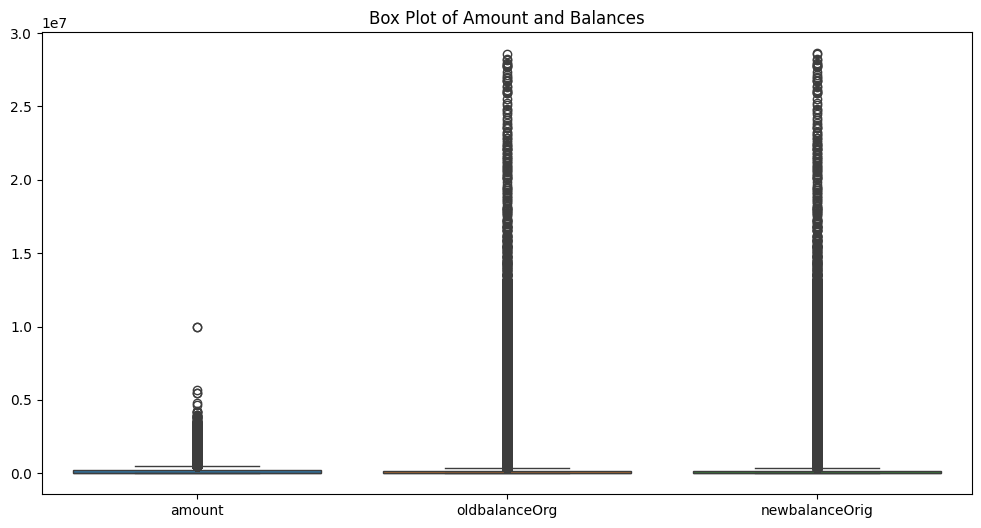

In [15]:
# 3. Visualization: Box Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[numeric_columns])
plt.title('Box Plot of Amount and Balances')
plt.show()


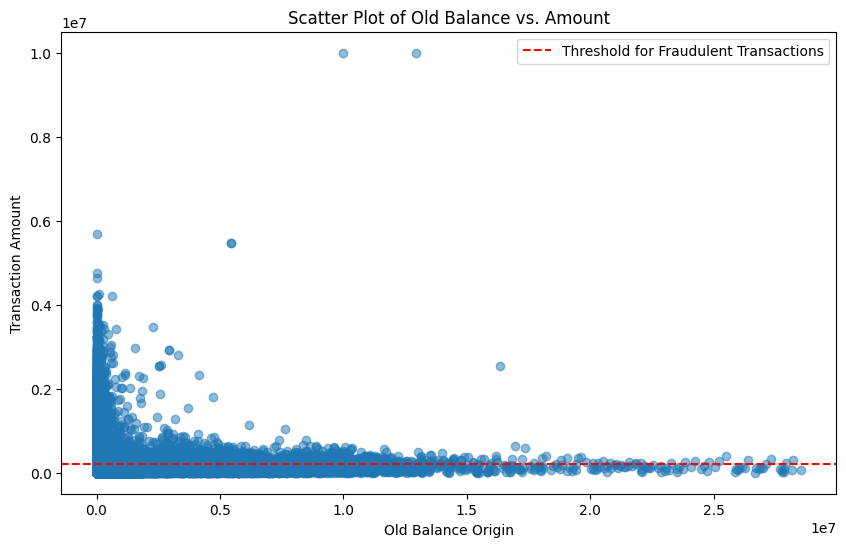

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(df['oldbalanceOrg'], df['amount'], alpha=0.5)
plt.title('Scatter Plot of Old Balance vs. Amount')
plt.xlabel('Old Balance Origin')
plt.ylabel('Transaction Amount')
plt.axhline(y=200000, color='r', linestyle='--', label='Threshold for Fraudulent Transactions')
plt.legend()
plt.show()

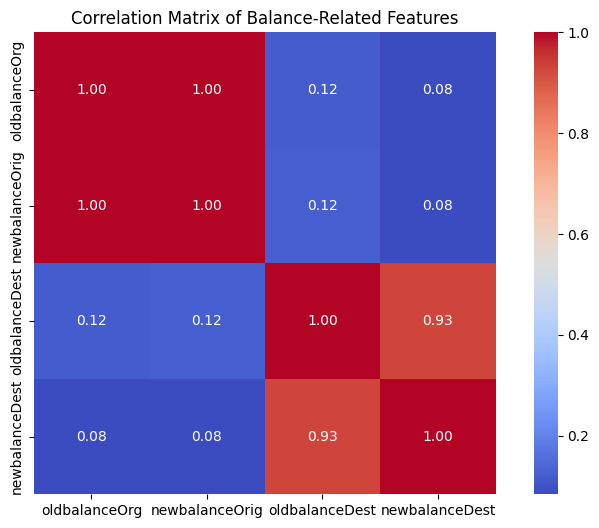

In [17]:
balance_features = ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
correlation_matrix = df[balance_features].corr()
plt.figure(figsize=(10, 6))

# Create a heatmap to visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)

# Set title and labels
plt.title('Correlation Matrix of Balance-Related Features')
plt.show()


In [18]:
df['balance_change_orig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balance_change_dest'] = df['newbalanceDest'] - df['oldbalanceDest']
df['total_balance'] = df['newbalanceOrig'] + df['newbalanceDest']

# Use transaction counts based on 'nameOrig' and 'nameDest'
df['transaction_count_orig'] = df.groupby('nameOrig')['step'].transform('count')
df['transaction_count_dest'] = df.groupby('nameDest')['step'].transform('count')

# Drop identifiers and any redundant features
df = df.drop(['nameOrig', 'nameDest'], axis=1)

# Handle categorical features using one-hot encoding for 'type'
df = pd.get_dummies(df, columns=['type'], drop_first=True)

In [19]:
print(df['isFraud'].isnull().sum())
df = df.dropna(subset=['isFraud'])
print(df.shape)


1
(56202, 18)


In [21]:
X = df.drop(['isFraud', 'isFlaggedFraud'], axis=1)  # Drop target and flag columns
y = df['isFraud']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [22]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [23]:
y_pred = rf_model.predict(X_test)

In [24]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)


In [25]:
print(f'Accuracy: {accuracy:.2f}')
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 1.00
Confusion Matrix:
[[16826     1]
 [   18    16]]
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     16827
         1.0       0.94      0.47      0.63        34

    accuracy                           1.00     16861
   macro avg       0.97      0.74      0.81     16861
weighted avg       1.00      1.00      1.00     16861



                   Feature  Importance
6      balance_change_orig    0.194287
1                   amount    0.162840
2            oldbalanceOrg    0.118919
4           oldbalanceDest    0.110688
7      balance_change_dest    0.089104
8            total_balance    0.080805
5           newbalanceDest    0.066681
0                     step    0.062764
10  transaction_count_dest    0.047482
15           type_TRANSFER    0.019875
11           type_CASH_OUT    0.017421
3           newbalanceOrig    0.015711
14            type_PAYMENT    0.012038
12              type_DEBIT    0.001385
9   transaction_count_orig    0.000000
13             type_PAYMEN    0.000000


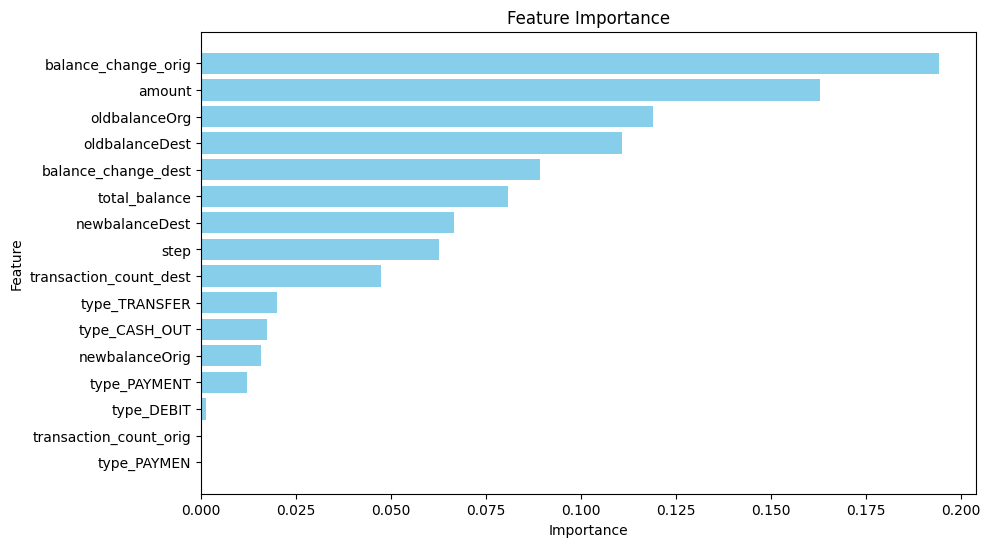

In [26]:
feature_importances = rf_model.feature_importances_

# Create a DataFrame to view feature names and their importance
features = X.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Print the feature importance
print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()